klue/roberta-small 모델 사용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ln -s /content/drive/MyDrive/ /gdrive

In [ ]:
!cp -r /gdrive/aicon/aicon_retrailer data/

In [ ]:
!pip install transformers datasets

     |████████████████████████████████| 2.8 MB 7.4 MB/s 
     |████████████████████████████████| 264 kB 66.4 MB/s 
     |████████████████████████████████| 3.3 MB 38.6 MB/s 
     |████████████████████████████████| 895 kB 83.1 MB/s 
     |████████████████████████████████| 50 kB 9.4 MB/s 
     |████████████████████████████████| 636 kB 78.7 MB/s 
     |████████████████████████████████| 243 kB 95.1 MB/s 
     |████████████████████████████████| 119 kB 76.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
import warnings
import re

import numpy as np
import pandas as pd

import datasets
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

import seaborn as sns

#import optuna
#from ray import tune

warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train = pd.read_csv("./data/train/train.csv")
valid = pd.read_csv("./data/val/val.csv")
test = pd.read_csv("./data/test/test.csv")

In [ ]:
dataset = pd.concat([train, valid], join='inner')

In [ ]:
map_dict = {'AS_날짜_요청': 0,'AS_날짜_질문': 1,'AS_방법_요청': 2,'AS_방법_질문': 3,'AS_비용_요청': 4,'AS_비용_질문': 5,
                        'AS_시간_질문': 6,'AS_일반_질문': 7,'결제_방식_질문': 8,'결제_수단_질문': 9,'결제_시기_질문': 10,'결제_영수증_질문': 11,
                        '결제_오류_질문': 12,'결제_일반_질문': 13,'결제_일반_확인': 14,'결제_재결제_질문': 15,'결제_추가_질문': 16,
                        '결제_취소_질문': 17,'결제_할인_질문': 18,'교환|반품|환불_방법_요청': 19,'교환|반품|환불_방법_질문': 20,
                        '교환|반품|환불_방법_확인': 21,'교환|반품|환불_비용_질문': 22,'교환|반품|환불_시간_요청': 23,
                        '교환|반품|환불_시간_질문': 24,'교환|반품|환불_일반_요청': 25,'교환|반품|환불_일반_질문': 26,
                        '교환|반품|환불_일반_확인': 27,'구매_예약_요청': 28,'구매_예약_질문': 29,'구매_제품_요청': 30,'구매_제품_질문': 31,
                        '매장_이용_요청': 32,'매장_이용_질문': 33,'매장_정보_질문': 34,'멤버십_사용_질문': 35,'멤버십_적립_질문': 36,
                        '배송_날짜_요청': 37,'배송_날짜_질문': 38,'배송_날짜_확인': 39,'배송_방법_요청': 40,'배송_방법_질문': 41,
                        '배송_방법_확인': 42,'배송_비용_질문': 43,'배송_오류_질문': 44,'배송_오류_확인': 45,'배송_일반_요청': 46,
                        '배송_일반_질문': 47,'배송_일반_확인': 48,'배송_지역_요청': 49,'배송_지역_질문': 50,'배송_택배사_질문': 51,
                        '부가서비스_날짜_요청': 52,'부가서비스_날짜_질문': 53,'부가서비스_방법_요청': 54,'부가서비스_방법_질문': 55,
                        '부가서비스_비용_요청': 56,'부가서비스_비용_질문': 57,'웹사이트_사용_질문': 58,'웹사이트_오류_질문': 59,
                        '제품_가격_비교': 60,'제품_가격_요청': 61,'제품_가격_질문': 62,'제품_가격_확인': 63,'제품_구성_요청': 64,
                        '제품_구성_질문': 65,'제품_구성_확인': 66,'제품_날짜_질문': 67,'제품_방법_요청': 68,'제품_방법_질문': 69,
                        '제품_방법_확인': 70,'제품_불량_요청': 71,'제품_불량_질문': 72,'제품_불량_확인': 73,'제품_소재_질문': 74,
                        '제품_시용_요청': 75,'제품_시용_질문': 76,'제품_용도_질문': 77,'제품_용도_확인': 78,'제품_원산지_질문': 79,
                        '제품_일반_비교': 80,'제품_일반_요청': 81,'제품_일반_질문': 82,'제품_일반_확인': 83,'제품_입고_요청': 84,
                        '제품_입고_질문': 85,'제품_재고_요청': 86,'제품_재고_질문': 87,'제품_재고_확인': 88,'제품_정보_비교': 89,
                        '제품_정보_요청': 90,'제품_정보_질문': 91,'제품_정보_확인': 92,'제품_추천_비교': 93,'제품_추천_요청': 94,
                        '제품_추천_질문': 95,'제품_추천_확인': 96,'제품_커스텀_요청': 97,'제품_커스텀_질문': 98,'제품_품질_비교': 99,
                        '제품_품질_요청': 100,'제품_품질_질문': 101,'제품_품질_확인': 102,'제품_호환_질문': 103,'제품_호환_확인': 104,
                        '포장_방식_요청': 105,'포장_방식_질문': 106,'포장_비용_질문': 107,'포장_일반_질문': 108,'행사_기간_질문': 109,
                        '행사_기간_확인': 110,'행사_날짜_질문': 111,'행사_유형_질문': 112,'행사_유형_확인': 113,'행사_일반_질문': 114,
                        '행사_일반_확인': 115,'행사_정보_요청': 116,'행사_정보_질문': 117}

In [ ]:
def set_values(row, value):
    return value[row]

In [ ]:
dataset['label'] = dataset['intent'].apply(set_values, args =(map_dict, ))

In [ ]:
dataset.label.value_counts(sort=False)*100/len(dataset)

0      0.043492
1      0.300441
2      0.183573
3      0.658514
4      0.045360
         ...   
113    0.055232
114    1.678305
115    0.090986
116    0.031752
117    0.771647
Name: label, Length: 118, dtype: float64

In [ ]:
dataset.label.value_counts(sort=False)

0       163
1      1126
2       688
3      2468
4       170
       ... 
113     207
114    6290
115     341
116     119
117    2892
Name: label, Length: 118, dtype: int64

In [ ]:
dataset.label.value_counts(sort = True)

91     72999
38     54908
69     28061
103    24785
65     18246
       ...  
63        71
9         70
78        70
35        66
42        60
Name: label, Length: 118, dtype: int64

In [ ]:
dataset.count()

conv_num    374783
intent      374783
question    374783
answer      374783
label       374783
dtype: int64

In [ ]:
dataset.head()

,conv_num,intent,question,answer,label
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0


In [ ]:
dataset['intent'].fillna('NAN', inplace=True)
dataset['question'].fillna('NAN', inplace=True)
dataset['answer'].fillna('NAN', inplace=True)

In [ ]:
dataset['data'] = dataset['question'] + dataset['answer']
test['data'] = test['question'] + test['answer']

In [ ]:
dataset.head()

,conv_num,intent,question,answer,label,data
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인..."
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다."
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실..."
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어..."
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다."


In [ ]:
test.head()

,conv_num,question,answer,data
0,9710,노트북 수리 맡기면 바로 받을 수 있나요?,오늘 바로 받으실 수 있어요.,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,9711,노트북 수리 맡기면 오늘 받을 수 있어요?,"네, 오늘 받으실 수 있습니다.","노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,9728,오늘 노트북 수리 들어가면 내일 찾을 수 있죠?,"네, 내일 찾아가세요.","오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,9737,어제 수리맡긴 노트북 내일 찾을 수 있습니까?,"네, 내일 찾으러 오시면 됩니다.","어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,11050,TV AS 이번주 안에 가능한가요?,"네, 이번주까지 해드리겠습니다.","TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


In [ ]:
dataset=dataset[['data','label']]
test=test[['data']]

In [ ]:
dataset.head()

,data,label
0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인...",0
1,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다.",0
2,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실...",0
3,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어...",0
4,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다.",0


In [ ]:
test.head()

,data
0,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,"노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,"오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,"어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,"TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


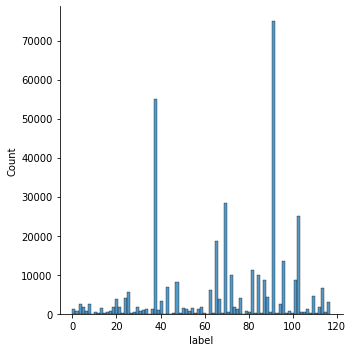

In [ ]:
sns.displot(dataset.label)

In [ ]:
model_checkpoint = "klue/roberta-small"
batch_size = 32
RANDOM_SEED = 42

In [ ]:
target = dataset['label']
dataset_train, dataset_val = train_test_split(dataset,test_size = 0.2, stratify = target, random_state = RANDOM_SEED)

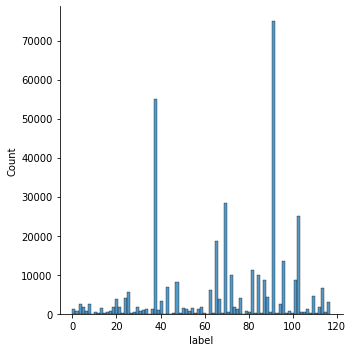

In [ ]:
sns.displot(dataset.label)

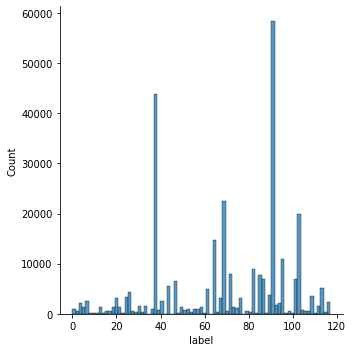

In [ ]:
sns.displot(dataset_train.label)

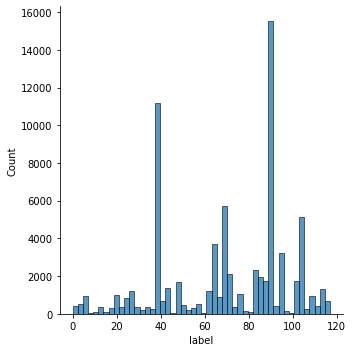

In [ ]:
sns.displot(dataset_val.label)

In [ ]:
def DroppingData(dataset, drop_label, drop_rate):
  counterFunc = dataset.apply(lambda x: True if x['label'] == drop_label else False , axis=1)
  num_rows = len(counterFunc[counterFunc == True].index)
  dropping = int(drop_rate * num_rows)
  dataset = dataset.drop(np.random.choice(dataset.index[dataset['label'].eq(drop_label)], dropping))

  return dataset

In [ ]:
major = [91, 38, 69, 103, 65]

In [ ]:
drop_labels = []
for i in range(118):
  drop_labels.append(i)
for i in major:
  drop_labels.remove(i)
drop_labels

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 66,
 67,
 68,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117]

In [ ]:
len(drop_labels)

113

In [ ]:
for i in drop_labels:
  dataset_train = DroppingData(dataset_train, i, 0.9)

In [ ]:
for i in drop_labels:
  dataset_val = DroppingData(dataset_val, i, 0.9)

In [ ]:
dataset_train.label.value_counts(sort = True)

91     55400
38     37445
69     22449
103    18685
65     13669
       ...  
110       22
35        21
45        21
9         18
42        17
Name: label, Length: 118, dtype: int64

In [ ]:
dataset_val.label.value_counts(sort = True)

91     14420
38     10591
69      5612
103     4884
65      3588
       ...  
78         6
110        5
88         5
63         5
42         5
Name: label, Length: 118, dtype: int64

In [ ]:
dataset_train.count()

data     200972
label    200972
dtype: int64

In [ ]:
dataset_val.count()

data     53139
label    53139
dtype: int64

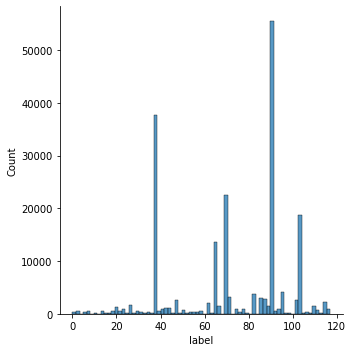

In [ ]:
sns.displot(dataset_train.label)

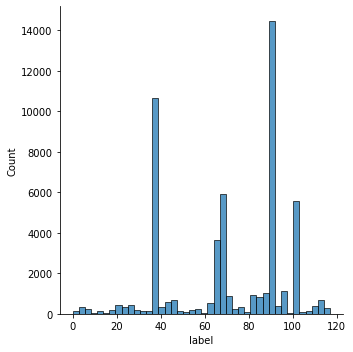

In [ ]:
sns.displot(dataset_val.label)

In [ ]:
dataset_train['label'] = dataset_train['label'].apply(lambda x: 200 if x not in major else x)

In [ ]:
dataset_val['label'] = dataset_val['label'].apply(lambda x: 200 if x not in major else x)

In [ ]:
dataset_train.label.value_counts(sort = True)

91     55400
200    53324
38     37445
69     22449
103    18685
65     13669
Name: label, dtype: int64

In [ ]:
dataset_val.label.value_counts(sort = True)

91     14420
200    14044
38     10591
69      5612
103     4884
65      3588
Name: label, dtype: int64

In [ ]:
dataset_train.count()

data     200972
label    200972
dtype: int64

In [ ]:
dataset_val.count()

data     53139
label    53139
dtype: int64

In [ ]:
origin_id = [200, 91, 38, 69, 103, 65]

In [ ]:
dataset_train['label'] = dataset_train['label'].apply(lambda x: 0 if x == 200 else x)
dataset_train['label'] = dataset_train['label'].apply(lambda x: 1 if x == 91 else x)
dataset_train['label'] = dataset_train['label'].apply(lambda x: 2 if x == 38 else x)
dataset_train['label'] = dataset_train['label'].apply(lambda x: 3 if x == 69 else x)
dataset_train['label'] = dataset_train['label'].apply(lambda x: 4 if x == 103 else x)
dataset_train['label'] = dataset_train['label'].apply(lambda x: 5 if x == 65 else x)

In [ ]:
dataset_val['label'] = dataset_val['label'].apply(lambda x: 0 if x == 200 else x)
dataset_val['label'] = dataset_val['label'].apply(lambda x: 1 if x == 91 else x)
dataset_val['label'] = dataset_val['label'].apply(lambda x: 2 if x == 38 else x)
dataset_val['label'] = dataset_val['label'].apply(lambda x: 3 if x == 69 else x)
dataset_val['label'] = dataset_val['label'].apply(lambda x: 4 if x == 103 else x)
dataset_val['label'] = dataset_val['label'].apply(lambda x: 5 if x == 65 else x)

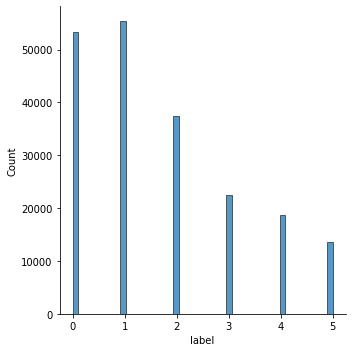

In [ ]:
sns.displot(dataset_train.label)

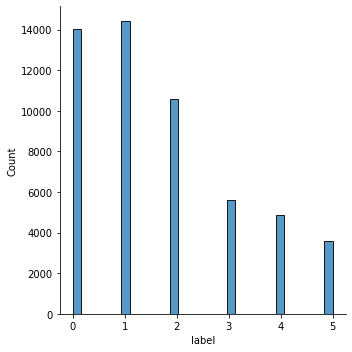

In [ ]:
sns.displot(dataset_val.label)

In [ ]:
ros = RandomOverSampler()
oversampled_data, oversampled_label = ros.fit_resample(dataset_train, dataset_train['label'])
dataset_train = pd.DataFrame(oversampled_data, columns=dataset_train.columns)

In [ ]:
ros = RandomOverSampler()
oversampled_data, oversampled_label = ros.fit_resample(dataset_val, dataset_val['label'])
dataset_val = pd.DataFrame(oversampled_data, columns=dataset_val.columns)

In [ ]:
dataset_train.label.value_counts(sort = True)

5    55400
4    55400
3    55400
2    55400
1    55400
0    55400
Name: label, dtype: int64

In [ ]:
dataset_val.label.value_counts(sort = True)

5    14420
4    14420
3    14420
2    14420
1    14420
0    14420
Name: label, dtype: int64

In [ ]:
dataset_train.count()

data     332400
label    332400
dtype: int64

In [ ]:
dataset_val.count()

data     86520
label    86520
dtype: int64

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [ ]:
def tokenized_dataset(dataset, tokenizer):
  tokenized_sentences = tokenizer(
      list(dataset['data']),
      return_tensors="pt",
      padding=True,
      truncation=True
      )
  return tokenized_sentences

In [ ]:
# Dataset 구성.
class ROBERTA_Dataset(Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
    def get_classes(self):
        return self.labels

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
submission.head()

,conv_num,intent
0,9710,카테고리_채우기
1,9711,카테고리_채우기
2,9728,카테고리_채우기
3,9737,카테고리_채우기
4,11050,카테고리_채우기


In [ ]:
submission['label'] = submission['intent']

In [ ]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,카테고리_채우기
1,9711,카테고리_채우기,카테고리_채우기
2,9728,카테고리_채우기,카테고리_채우기
3,9737,카테고리_채우기,카테고리_채우기
4,11050,카테고리_채우기,카테고리_채우기


In [ ]:
submission.loc[submission.label == '카테고리_채우기', 'label'] = 0

In [ ]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,0
1,9711,카테고리_채우기,0
2,9728,카테고리_채우기,0
3,9737,카테고리_채우기,0
4,11050,카테고리_채우기,0


In [ ]:
train_label=dataset_train['label'].values
val_label=dataset_val['label'].values
test_label=submission['label'].values

tokenized_train = tokenized_dataset(dataset_train, tokenizer)
tokenized_val = tokenized_dataset(dataset_val, tokenizer)
tokenized_test = tokenized_dataset(test, tokenizer)

data_train = ROBERTA_Dataset(tokenized_train, train_label)
data_val = ROBERTA_Dataset(tokenized_val, val_label)
data_test = ROBERTA_Dataset(tokenized_test, test_label)

In [ ]:
import gc
gc.collect()

50

In [ ]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'cla

In [ ]:
metric = load_metric("glue", "mnli")

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    "saved",
    evaluation_strategy="steps",
    save_steps = 20780,
    eval_steps = 20780, 
    logging_steps = 20780, 
    learning_rate=2e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    seed = 42
)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=data_train,
    eval_dataset=data_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file https://huggingface.co/klue/roberta-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6aa0817a5b48e36ec821c3d9cb8267f2dda41a32b317311688f06c742b6b2a1d.7f009d6b27d54554dce063a5fc8273742e9a198f6f627aada4bc5ea2dbbc0313
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_a

In [ ]:
trainer.train()

loading configuration file https://huggingface.co/klue/roberta-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6aa0817a5b48e36ec821c3d9cb8267f2dda41a32b317311688f06c742b6b2a1d.7f009d6b27d54554dce063a5fc8273742e9a198f6f627aada4bc5ea2dbbc0313
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_a

Step,Training Loss,Validation Loss,Accuracy
20780,0.606900,0.626628,0.796267
41560,0.522300,0.625694,0.803895
62340,0.436700,0.744833,0.801179
83120,0.414000,0.791405,0.797076
103900,0.346300,0.984190,0.790950


***** Running Evaluation *****
  Num examples = 86520
  Batch size = 8
Saving model checkpoint to saved/checkpoint-20780
Configuration saved in saved/checkpoint-20780/config.json
Model weights saved in saved/checkpoint-20780/pytorch_model.bin
tokenizer config file saved in saved/checkpoint-20780/tokenizer_config.json
Special tokens file saved in saved/checkpoint-20780/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 86520
  Batch size = 8
Saving model checkpoint to saved/checkpoint-41560
Configuration saved in saved/checkpoint-41560/config.json
Model weights saved in saved/checkpoint-41560/pytorch_model.bin
tokenizer config file saved in saved/checkpoint-41560/tokenizer_config.json
Special tokens file saved in saved/checkpoint-41560/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 86520
  Batch size = 8
Saving model checkpoint to saved/checkpoint-62340
Configuration saved in saved/checkpoint-62340/config.json
Model weights saved in saved/ch

TrainOutput(global_step=124650, training_loss=0.4439226709787405, metrics={'train_runtime': 29564.2789, 'train_samples_per_second': 33.73, 'train_steps_per_second': 4.216, 'total_flos': 5.90864337232272e+16, 'train_loss': 0.4439226709787405, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 86520
  Batch size = 8


{'epoch': 3.0,
 'eval_accuracy': 0.8038950531668978,
 'eval_loss': 0.6256935000419617,
 'eval_runtime': 576.8186,
 'eval_samples_per_second': 149.995,
 'eval_steps_per_second': 18.749}

In [ ]:
pred = trainer.predict(data_test)
pred = pred[0]
pred

***** Running Prediction *****
  Num examples = 40730
  Batch size = 8


array([[ 5.7869306 , -0.13035317, -0.7169789 , -1.2326406 , -2.5862672 ,
        -1.5628875 ],
       [ 5.846852  , -0.26561737, -0.57085496, -1.5339833 , -2.5077276 ,
        -1.4251919 ],
       [ 5.8598666 , -0.10660967, -1.0076355 , -1.7184417 , -2.4287963 ,
        -1.056986  ],
       ...,
       [ 5.7951236 ,  0.24732348, -1.8440937 , -1.0270505 , -2.687685  ,
        -0.94573313],
       [ 5.85837   ,  0.23020072, -1.3317467 , -1.6457659 , -2.6734037 ,
        -0.8948163 ],
       [ 5.8687325 ,  0.17956798, -1.5137801 , -1.5525142 , -2.4345872 ,
        -1.0092392 ]], dtype=float32)

In [ ]:
np.save("/gdrive/aicon/aicon_retrailer/npy/pred_classifier1_0.npy", pred)

In [ ]:
pred = np.argmax(pred,1)
submission['label'] = pred

In [ ]:
#dict_map = {v : k for k, v in map_dict.items()}

#dict_map

In [ ]:
"""
submission['intent'] = submission['label'].apply(set_values, args =(dict_map, ))
submission =submission.drop('label', axis=1)
submission.head()
"""

"\nsubmission['intent'] = submission['label'].apply(set_values, args =(dict_map, ))\nsubmission =submission.drop('label', axis=1)\nsubmission.head()\n"

In [ ]:
submission.to_csv("/gdrive/aicon/aicon_retrailer/result/klue_roberta_small_trainer_classifier1_0.csv",index=False)

In [ ]:
!cp -r ./saved/checkpoint-103900 /gdrive/aicon/aicon_retrailer/backup

참고문헌  
transformers 공식문서 How to fine-tune a model on text classification
https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb  

